# Training the model

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from numpy import datetime64
import re
print(tf.__version__)


2.12.0


## Parameters

In [2]:
window_size = 10
batch_size = 32
shuffle_buffer = 1000



## Data

Some data is missing due to orbitting reasons. Do interpolation.

In [3]:

df=pd.read_csv('data/52028209n.csv')

#df = df.T # transposing is needed for bbd-ts not gathered via web API
#df.columns=['date', 'mov']
#time = np.arange(len(df['mov']))

df.head()


,date_20150401,date_20150413,date_20150425,date_20150507,date_20150531,date_20150612,date_20150624,date_20150706,date_20150718,date_20150730,...,date_20211026,date_20211101,date_20211107,date_20211113,date_20211119,date_20211125,date_20211201,date_20211207,date_20211213,date_20211219
0,0,-7.01397,-4.92418,-4.61962,-3.69301,-5.83622,-4.80441,-5.15415,-2.28502,3.51015,...,0.526968,-4.62996,2.9803,0.224511,-0.954579,-5.80441,-0.312103,-6.32671,-0.969059,-0.227574


## Adding missing days

In [4]:
# Get acquisition dates from column names
day_flag = 'date_'
regxx = day_flag

dats   = []
nodats = []
for c in df.columns:
    if re.findall(regxx,c):
        dats.append(c)
    else:
        nodats.append(c)
        
dt_dats = [datetime64(c[5:9]+'-'+c[9:11]+'-'+c[11:13]) for c in dats]


In [5]:
# fill in missing dates

dt_dats_padded = [dt_dats[0]]

old_date = dt_dats[0]
while old_date<dt_dats[-1]:
    old_date += 6
    dt_dats_padded.append(old_date)

#print(dt_dats_padded)

dt_dats_asDays = (dt_dats-dt_dats[0]).astype('float')
dt_dats_asDays_padded = (dt_dats_padded-dt_dats_padded[0]).astype('float')

print(type(dt_dats_asDays_padded),type(dt_dats_asDays))
print(len(dt_dats_padded), len(dt_dats_asDays_padded))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
410 410


In [6]:
# Interpolate values


this_ps = df.iloc[0]
this_ts = this_ps[dats]
this_mv = this_ps[nodats]


# padding missing values in a six-day rhythm
# with linearly interpolated data

# allocating new lists
this_ts_padded = [this_ts[0]]

# fill in missing values
this_ts_padded = np.interp(dt_dats_asDays_padded, dt_dats_asDays, this_ts.astype('float'))
#print(np.max(this_ts_padded), np.min(this_ts_padded))
n_max = np.max(this_ts_padded)
n_min = np.min(this_ts_padded)

this_ps_padded = [*this_mv, *this_ts_padded]
this_ps_padded = np.asarray(this_ps_padded).T

   

In [7]:
print(min(this_ps_padded), max(this_ps_padded))


-19.3318004608154 7.05695009231567


## Plot Input Data

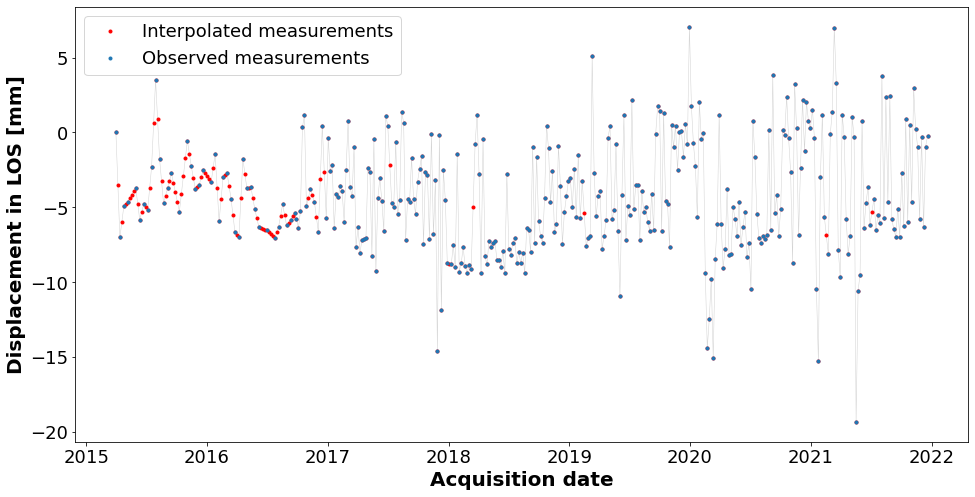

In [8]:
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=[16,8])
plt.plot(dt_dats_padded, this_ps_padded,color='lightgray', linewidth=0.5)
plt.plot(dt_dats_padded, this_ps_padded,'r.', label='Interpolated measurements')
plt.plot(dt_dats, this_ps.values,'.', label='Observed measurements')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

## Detrending - take care of "%%script"-option

In [9]:
%%script echo skipping
series2 = np.copy(series) # make a copy!

myfit = np.polyfit(time, series,1)
mytrend = np.polyval(myfit, time)

series_trendfree = [i-j for i,j in zip(series,mytrend)]
series_trendfree = np.asarray(series_trendfree)
print(np.min(series_trendfree))


plt.figure(figsize=[16,9])
plt.plot(time, series)
plt.plot(time, series_trendfree, 'r', linewidth=3)

skipping


In [10]:
# Decide, what data to use: series or the trendfree one
# THIS IS THE POINT TO START OVER WHEN SOMETHING WENT WRONG

time = dt_dats_asDays_padded
this_signal = this_ps_padded #or


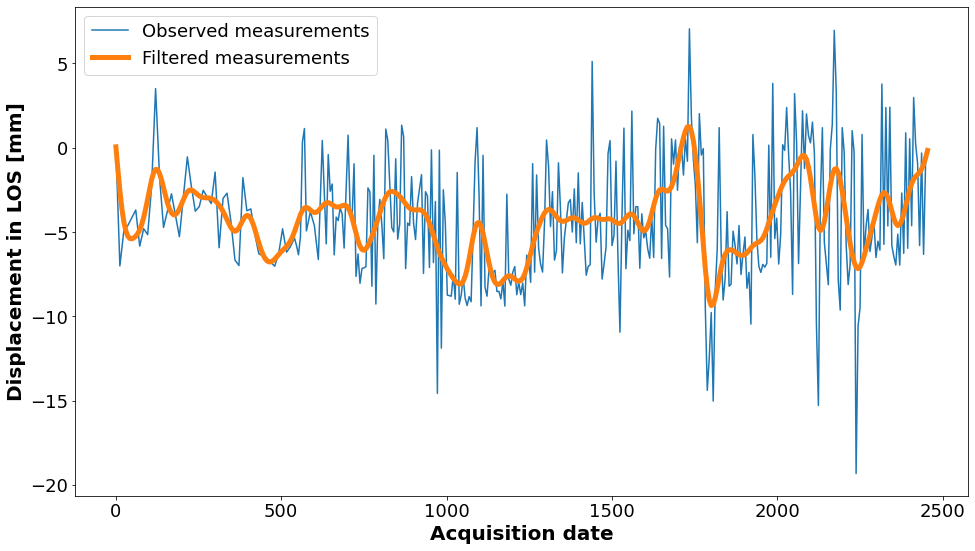

In [11]:
from scipy import signal

omega_g = 1./90      #cut off frequency
fs      = 1./6     

this_omega_g = omega_g
sos = signal.butter(3, this_omega_g, 'lp', fs=fs, output='sos')
this_signal_filtered = signal.sosfiltfilt(sos, this_signal)

plt.figure(figsize=[16,9])
plt.plot(time, this_signal, label='Observed measurements')
plt.plot(time, this_signal_filtered, linewidth=5, label='Filtered measurements')

this_signal = this_signal_filtered
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)



In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## **Split dataset**

In [13]:
# Define the split time
split_time = 340



# Get the train set 
time_train = time[:split_time]
x_train = this_signal[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = this_signal[split_time:]

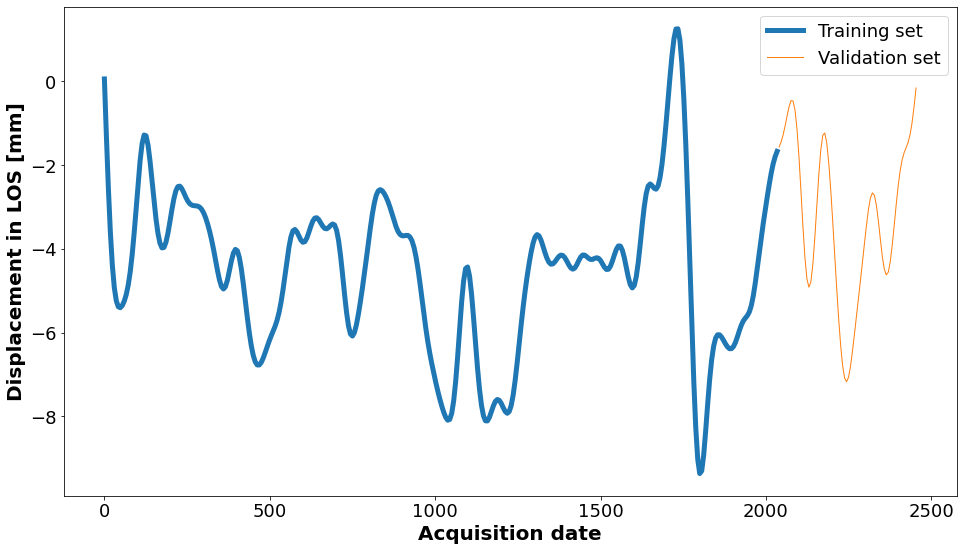

In [14]:
# Plot the train set
plt.figure(figsize=[16,9])
plt.plot(time_train, x_train, linewidth=5, label='Training set')
plt.plot(time_valid, x_valid, linewidth=1, label='Validation set')
plt.ylabel('Displacement in LOS [mm]', fontsize = 20, fontweight='bold')
plt.xlabel('Acquisition date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [15]:

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)

In [16]:
# Print the results
#for x,y in wdf:
#  print("x = ", x.numpy())
#  print("y = ", y.numpy())
 # print()

In [17]:


# Print properties of a single batch
for windows in train_set.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')



data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 10)
shape of second element: (32,)


# The AI-part

## The model

There's another model at the end of this notebook: the "Sunspot model" from Coursera's Tensorflow Time Series Course (where this is taken from, too).

### 1. Setting up the model

In [18]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 20.)
])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 10, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Get initial weights
init_weights = model.get_weights()

### 2.1 Try to find the best learning rate

In [20]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
11/11 [==============================] - 4s 35ms/step - loss: 2.3538 - lr: 1.0000e-08
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 2.3490 - lr: 1.1220e-08
Epoch 3/100
11/11 [==============================] - 0s 14ms/step - loss: 2.3419 - lr: 1.2589e-08
Epoch 4/100
11/11 [==============================] - 0s 14ms/step - loss: 2.3334 - lr: 1.4125e-08
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3235 - lr: 1.5849e-08
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 2.3125 - lr: 1.7783e-08
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 2.3000 - lr: 1.9953e-08
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 2.2860 - lr: 2.2387e-08
Epoch 9/100
11/11 [==============================] - 0s 14ms/step - loss: 2.2704 - lr: 2.5119e-08
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 2.2530 - lr: 2.8184e-08
Epoch 11/100
11/11 

Epoch 84/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3541 - lr: 1.4125e-04
Epoch 85/100
11/11 [==============================] - 0s 13ms/step - loss: 0.4112 - lr: 1.5849e-04
Epoch 86/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3878 - lr: 1.7783e-04
Epoch 87/100
11/11 [==============================] - 0s 13ms/step - loss: 0.2490 - lr: 1.9953e-04
Epoch 88/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2836 - lr: 2.2387e-04
Epoch 89/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2552 - lr: 2.5119e-04
Epoch 90/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2784 - lr: 2.8184e-04
Epoch 91/100
11/11 [==============================] - 0s 25ms/step - loss: 0.2256 - lr: 3.1623e-04
Epoch 92/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2347 - lr: 3.5481e-04
Epoch 93/100
11/11 [==============================] - 0s 12ms/step - loss: 0.4575 - lr: 3.9811e-04
Epoch 94/1

### 2.2 Inspect learning rate

(1e-08, 0.001, 0.0, 50.0)

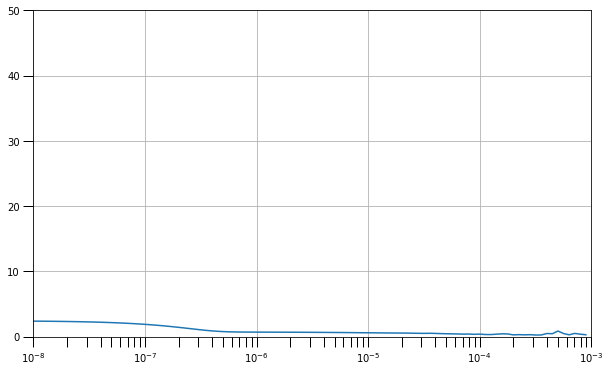

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])




### 3. Train the model

In [22]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


In [ ]:
# Set the learning rate
learning_rate = 1e-3

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=500)

skipping


### 4. Save the model 
If you want to, uncomment the skipping in the following cell

In [23]:
%%script echo skipping
fit_fresh_model = False
if fit_fresh_model: 
  model.save('model/experiment001v1')

skipping


**This is what you need to load the saved model**

In [24]:
%%script echo skipping
model = tf.keras.models.load_model('model/experiment001')

skipping
